# Download Datasets

In [1]:
!pip install torchmetrics
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
import json
import os
import zipfile
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from torchmetrics.classification import BinaryAccuracy
import pytorch_lightning as pl
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [3]:
zip_path = '/content/QMSum.zip'
extract_path = '/content/QMSum'

In [4]:
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed.")

Extraction completed.


In [5]:
QMSum_path = '/content/QMSum/QMSum'

In [6]:
files = {
    "train": [],
    "val": [],
    "test": []
}

for split in files.keys():
    for file in os.listdir(f"{QMSum_path}/data/ALL/{split}"):
        if file.endswith(".json"):
            files[split].append(f"{QMSum_path}/data/ALL/{split}/{file}")

# One Utterance + Cross Encoder Score Datasets

## Class Dataset

In [ ]:
class UttCrossEncDatasets(Dataset):
    def __init__(self, json_files: List[str], encoder):
        self.data = []  # store each example here
        self.encoder = encoder

        for json_file in json_files:
            file_info = self._load_json(json_file)
            self.data.append(file_info)

    def _load_json(self, json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)

        # chunk and encode the utterances
        utterances = [f"{i} {t['speaker']}: {t['content']}" for i,t in enumerate(data['meeting_transcripts'])]

        questions = []

        for item in data['specific_query_list']:
            query = item['query']

            spans = item['relevant_text_span']
            labels = [0] * len(utterances)

            for span in spans:
                start, end = int(span[0]), int(span[1])
                for i in range(start, end + 1):
                    labels[i] = 1

            labels = torch.tensor(labels, dtype=torch.float32)
            scores = self.score_utterances(query, utterances)

            questions.append({
                'query': query,
                'scores': scores,
                'labels': labels,
            })

        file_info = {
            "utterances": utterances,
            "questions": questions
        }
        return file_info
    def score_utterances(self, query, utterances):
        inputs = [(query, utt) for utt in utterances]
        scores = self.encoder.predict(inputs)
        return scores

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'utterances': item['utterances'],
            'questions': item['questions']
        }

In [ ]:
from sentence_transformers import CrossEncoder
encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [ ]:
print("Datasets are loading...")
train_dataset = UttCrossEncDatasets(files['train'], encoder_model)
val_dataset = UttCrossEncDatasets(files['val'], encoder_model)
test_dataset = UttCrossEncDatasets(files['test'], encoder_model)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Datasets are loading...
Train dataset size: 162
Validation dataset size: 35
Test dataset size: 35


### Score Analysis

In [ ]:
def plot_scores(dataset, data_idx, question_idx):
    question = train_dataset[data_idx]['questions'][question_idx]
    scores = question['scores']
    labels = question['labels']

    scores = scores.detach().cpu().numpy() if hasattr(scores, "detach") else scores
    labels = labels.detach().cpu().numpy() if hasattr(labels, "detach") else labels

    x = list(range(len(scores)))
    colors = ['green' if label == 1 else 'red' for label in labels]

    plt.figure(figsize=(12, 6))
    plt.scatter(x, scores, c=colors)
    plt.xlabel("Utterance Index")
    plt.ylabel("Relevance Score")
    plt.title(f"Utterance Relevance Scores")
    plt.grid(True)
    plt.show()


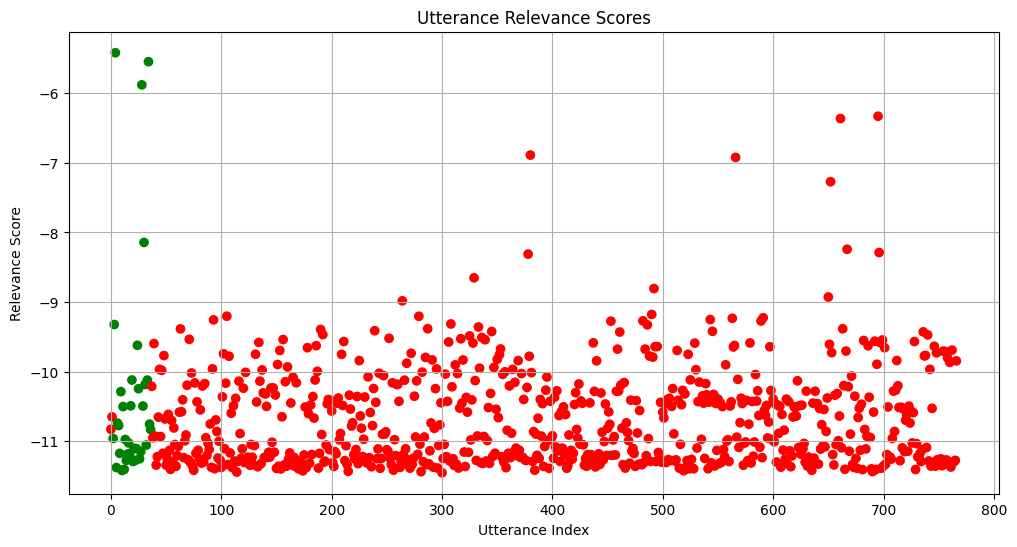

In [ ]:
plot_scores(train_dataset, 111, 0)

In [ ]:
def evaluate_topk_accuracy(dataset, top_k):
    """
    Evaluates the fraction of questions where at least one of the top-k scoring utterances is relevant.

    Args:
        dataset (UttCrossEncDatasets): The dataset object.
        top_k (int): The number of top scoring utterances to consider.

    Returns:
        float: Fraction of questions with at least one relevant utterance in the top-k.
    """
    total_questions = 0
    correct_count = 0
    correct_labels = 0
    total_labels = 0

    for example in dataset.data:
        for question in example['questions']:
            scores = question['scores']
            labels = question['labels']

            # Get indices of top-k scores
            topk_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_k]

            # Check if any of the top-k indices have label 1
            if any(labels[i] == 1 for i in topk_indices):
                correct_count += 1

            for i in topk_indices:
                if labels[i] == 1:
                  correct_labels += 1
                total_labels += 1

            total_questions += 1

    is_in_accuracy = correct_count / total_questions if total_questions > 0 else 0.0
    accuracy = correct_labels / total_labels if total_labels > 0 else 0.0

    return is_in_accuracy, accuracy

In [ ]:
is_in_accuracy, accuracy = evaluate_topk_accuracy(train_dataset, top_k=5)
print(f"Top-{5} is_in_accuracy: {is_in_accuracy:.2f}")
print(f"Top-{5} accuracy: {accuracy:.2f}")

Top-5 is_in_accuracy: 0.81
Top-5 accuracy: 0.34


In [ ]:
is_in_accuracy, accuracy = evaluate_topk_accuracy(train_dataset, top_k=3)
print(f"Top-{3} is_in_accuracy: {is_in_accuracy:.2f}")
print(f"Top-{3} accuracy: {accuracy:.2f}")

Top-3 is_in_accuracy: 0.74
Top-3 accuracy: 0.41


In [ ]:
is_in_accuracy, accuracy = evaluate_topk_accuracy(train_dataset, top_k=1)
print(f"Top-{1} is_in_accuracy: {is_in_accuracy:.2f}")
print(f"Top-{1} accuracy: {accuracy:.2f}")

Top-1 is_in_accuracy: 0.51
Top-1 accuracy: 0.51


In [ ]:
def max_utterance_lenght(dataset):
    max_length = 0
    for item in dataset:
        length = len(item['utterances'])
        if length > max_length:
            max_length = length
    print(f"max utterances in the dataset is {max_length}")
    return max_length

In [ ]:
max_utterance_lenght(train_dataset)
max_utterance_lenght(val_dataset)
max_utterance_lenght(test_dataset)

max utterances in the dataset is 1832
max utterances in the dataset is 1259
max utterances in the dataset is 1368


1368

## NN prediction

In [ ]:
class ScoresLabelsDataset(Dataset):
    def __init__(self, dataset, target_length):
      self.target_length = target_length
      X = []
      Y = []
      for item in dataset:
        questions = item['questions']
        for question in questions:
          scores = question['scores']
          labels = question['labels']

          padded_scores, padded_labels = self.pad_scores_labels(scores, labels)

          X.append(padded_scores)
          Y.append(padded_labels)

        self.X = torch.tensor(X, dtype=torch.float32)  # shape: (sample, 1832)
        self.Y = torch.tensor(Y, dtype=torch.float32)  # shape: (sample, 1832)

    def pad_scores_labels(self, scores, labels):
      scores = list(scores)
      labels = list(labels)
        # Truncate if too long
      if len(scores) > self.target_length:
          scores = scores[:self.target_length]
          labels = labels[:self.target_length]
      # Pad if too short
      elif len(scores) < self.target_length:
          pad_len = self.target_length - len(scores)
          scores = scores + [0.0] * pad_len
          labels = labels + [0] * pad_len
      return scores, labels


    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
class MultiLabelClassifier(pl.LightningModule):
    def __init__(self, input_dim=1832, hidden_dim1=512, hidden_dim2=128, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, input_dim),  # output same shape as input
            nn.Sigmoid()
        )
        self.loss_fn = nn.BCELoss()
        self.accuracy = BinaryAccuracy(multidim_average='global', threshold=0.5)

        self.test_preds = []
        self.test_targets = []

    def forward(self, x):
        return self.model(x)

    def _step(self, batch, stage):
        x, y = batch  # x, y shape: (B, 1832)
        y_hat = self(x)
        y_pred = (y_hat > 0.5).int()
        loss = self.loss_fn(y_hat, y)
        acc = self.accuracy(y_hat, y.int())
        self.log(f"{stage}_loss", loss, prog_bar=True)
        self.log(f"{stage}_acc", acc, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_pred = (y_hat > 0.5).int()

        self.test_preds.append(y_pred.cpu())
        self.test_targets.append(y.int().cpu())

        loss = self.loss_fn(y_hat, y)
        acc = self.accuracy(y_hat, y.int())
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss

    def on_test_epoch_end(self):
        # Stack predictions and targets
        y_true = torch.cat(self.test_targets, dim=0).numpy()
        y_pred_probs = torch.cat(self.test_preds, dim=0).numpy()

        # Convert probabilities to binary predictions for metrics that require binary input
        y_pred_binary = (y_pred_probs > 0.5).astype(int)

        # Calculate metrics using sklearn
        precision = precision_score(y_true, y_pred_binary, average='samples', zero_division=0)
        recall = recall_score(y_true, y_pred_binary, average='samples', zero_division=0)
        f1 = f1_score(y_true, y_pred_binary, average='samples', zero_division=0)

        # Calculate intersection and union for IoU (using binary predictions)
        intersection = np.logical_and(y_pred_binary, y_true).sum()
        union = np.logical_or(y_pred_binary, y_true).sum()
        total_pred_1 = y_pred_binary.sum()

        # Compute IoU and percent of predicted 1s that intersect with true 1s
        iou = intersection / union if union > 0 else 0.0
        percent_intersect = intersection / total_pred_1 if total_pred_1 > 0 else 0.0

        # Calculate accuracy
        acc = accuracy_score(y_true, y_pred_binary)

        # Log to PyTorch Lightning
        self.log("test_precision", precision)
        self.log("test_recall", recall)
        self.log("test_f1", f1)
        self.log("test_iou", iou)
        self.log("test_percent_intersect", percent_intersect)

        # Display results
        print(f"\nTest Metrics (Average):")
        print(f"Precision:         {precision:.4f}")
        print(f"Recall:            {recall:.4f}")
        print(f"F1 Score:          {f1:.4f}")
        print(f"Accuracy:          {acc:.4f}")
        print(f"IoU:               {iou:.4f}")
        print(f"Percent Intersect: {percent_intersect:.4f}")

        # Reset for next test epoch
        self.test_preds = []
        self.test_targets = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
class MultiLabelClassifier(pl.LightningModule):
    def __init__(self, input_dim=1832, hidden_dim1=512, hidden_dim2=128, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, input_dim),  # output same shape as input
            nn.Sigmoid()
        )
        self.loss_fn = nn.MSELoss()

        self.test_preds = []
        self.test_targets = []

    def forward(self, x):
        return self.model(x)

    def _step(self, batch, stage):
        x, y = batch  # x, y shape: (B, 1832)
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)

        # Only log accuracy for monitoring purposes, no thresholding affects the training
        self.log(f"{stage}_loss", loss, prog_bar=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        loss = self._step(batch, "val")

        # For validation, we can calculate and log additional metrics
        # without affecting the training process
        x, y = batch
        y_hat = self(x)

        # Calculate validation accuracy using threshold (for monitoring only)
        y_pred_binary = (y_hat > 0.5).int()
        val_acc = (y_pred_binary == y.int()).float().mean()
        self.log("val_acc", val_acc, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # Store raw predictions (probabilities) and targets
        self.test_preds.append(y_hat.detach().cpu())
        self.test_targets.append(y.detach().cpu())

        loss = self.loss_fn(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)

        # Threshold is only applied here for testing metrics, not for training
        y_pred_binary = (y_hat > 0.5).int()
        test_acc = (y_pred_binary == y.int()).float().mean()
        self.log("test_acc", test_acc, prog_bar=True)

        return loss

    def on_test_epoch_end(self):
        # Stack predictions and targets
        y_true = torch.cat(self.test_targets, dim=0).numpy()
        y_pred_probs = torch.cat(self.test_preds, dim=0).numpy()

        # Calculate MSE for raw probabilistic predictions
        mse = ((y_pred_probs - y_true) ** 2).mean()

        # Convert probabilities to binary predictions for metrics that require binary input
        y_pred_binary = (y_pred_probs > 0.5).astype(int)

        # Calculate metrics using sklearn
        precision = precision_score(y_true, y_pred_binary, average='samples', zero_division=0)
        recall = recall_score(y_true, y_pred_binary, average='samples', zero_division=0)
        f1 = f1_score(y_true, y_pred_binary, average='samples', zero_division=0)

        # Calculate intersection and union for IoU (using binary predictions)
        intersection = np.logical_and(y_pred_binary, y_true).sum()
        union = np.logical_or(y_pred_binary, y_true).sum()
        total_pred_1 = y_pred_binary.sum()

        # Compute IoU and percent of predicted 1s that intersect with true 1s
        iou = intersection / union if union > 0 else 0.0
        percent_intersect = intersection / total_pred_1 if total_pred_1 > 0 else 0.0

        # Calculate accuracy
        acc = accuracy_score(y_true, y_pred_binary)

        # Log to PyTorch Lightning
        self.log("test_mse", mse)
        self.log("test_precision", precision)
        self.log("test_recall", recall)
        self.log("test_f1", f1)
        self.log("test_iou", iou)
        self.log("test_percent_intersect", percent_intersect)

        # Display results
        print(f"\nTest Metrics (Average):")
        print(f"MSE:                {mse:.6f}")
        print(f"Precision:          {precision:.4f}")
        print(f"Recall:             {recall:.4f}")
        print(f"F1 Score:           {f1:.4f}")
        print(f"Accuracy:           {acc:.4f}")
        print(f"IoU:                {iou:.4f}")
        print(f"Percent Intersect:  {percent_intersect:.4f}")

        # Reset for next test epoch
        self.test_preds = []
        self.test_targets = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
from sklearn.model_selection import train_test_split

target_length = 1832
batch_size = 64

train = ScoresLabelsDataset(train_dataset, target_length)
val = ScoresLabelsDataset(val_dataset, target_length)
test = ScoresLabelsDataset(test_dataset, target_length)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor="val_loss",     # metric to monitor
    patience=10,            # stop after 10 epochs of no improvement
    mode="min",             # minimize val_loss
    verbose=True
)
trainer = Trainer(
    max_epochs=100,
    callbacks=[early_stop_callback],
    accelerator="auto",
    log_every_n_steps=1
)


model = MultiLabelClassifier(input_dim=1832)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 1.2 M  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.962     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.042


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.031


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.031


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.031


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.031


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.030


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.030


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.030


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.029


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.029


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.028. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]


Test Metrics (Average):
MSE:                0.027260
Precision:          0.0000
Recall:             0.0000
F1 Score:           0.0000
Accuracy:           0.0000
IoU:                0.0000
Percent Intersect:  0.0000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9701974391937256     │
│          test_f1          │            0.0            │
│         test_iou          │            0.0            │
│         test_loss         │   0.027259808033704758    │
│         test_mse          │    0.02725980617105961    │
│  test_percent_intersect   │            0.0            │
│      test_precision       │            0.0            │
│        test_recall        │            0.0            │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.027259808033704758,
  'test_acc': 0.9701974391937256,
  'test_mse': 0.02725980617105961,
  'test_precision': 0.0,
  'test_recall': 0.0,
  'test_f1': 0.0,
  'test_iou': 0.0,
  'test_percent_intersect': 0.0}]

## fix length span

In [ ]:
def predict_labels_fix_lenght_span(dataset, span_size, top_k=5):
  metrics = {
        'precision': [],
        'recall': [],
        'f1': [],
        'accuracy': [],
        'iou': [],
        'percent_intersect': []
    }

  for item in dataset:
    utterances = item['utterances']
    questions = item['questions']
    for question in questions:
      scores = question['scores']
      labels = question['labels']

      scores_tensor = torch.tensor(scores)
      topk = torch.topk(scores_tensor, top_k)
      topk_indices = topk.indices.tolist()

      predicted_labels = [0] * len(utterances)
      for i in topk_indices:
        start = max(0, i - span_size // 2)
        end = min(len(utterances), i + span_size // 2 + 1)
        for j in range(start, end):
                    predicted_labels[j] = 1

      # Compute metrics
      pred = torch.tensor(predicted_labels)
      true = torch.tensor(labels).int()

      intersection = (pred & true).sum().item()
      union = (pred | true).sum().item()
      total_pred_1 = pred.sum().item()

      precision = precision_score(true, pred, zero_division=0)
      recall = recall_score(true, pred, zero_division=0)
      f1 = f1_score(true, pred, zero_division=0)
      accuracy = accuracy_score(true, pred)
      iou = intersection / union if union > 0 else 0.0
      percent_intersect = intersection / total_pred_1 if total_pred_1 > 0 else 0.0

      metrics['precision'].append(precision)
      metrics['recall'].append(recall)
      metrics['f1'].append(f1)
      metrics['accuracy'].append(accuracy)
      metrics['iou'].append(iou)
      metrics['percent_intersect'].append(percent_intersect)

    # Average over all questions
    avg_metrics = {k: sum(v)/len(v) if len(v) > 0 else 0.0 for k, v in metrics.items()}
    return avg_metrics, metrics

In [ ]:
span_size = 128
top_k = 5
avg_metrics, metrics = predict_labels_fix_lenght_span(test_dataset, span_size, top_k)

<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

In [ ]:
print(avg_metrics)

{'precision': 0.22133530066843266, 'recall': 0.947411003236246, 'f1': 0.30867975509251183, 'accuracy': 0.36333333333333334, 'iou': 0.19966863400176602, 'percent_intersect': 0.22133530066843266}


In [ ]:
def plot_metrics_by_span_and_topk(dataset, span_sizes: List[int], top_ks: List[int], dataset_name):
    import matplotlib.pyplot as plt
    import numpy as np

    metric_names = ['recall', 'precision', 'f1', 'accuracy', 'iou', 'percent_intersect']
    results = {metric: [] for metric in metric_names}
    labels = []

    for span in span_sizes:
        for top_k in top_ks:
            avg_metrics, _ = predict_labels_fix_lenght_span(dataset, span, top_k)
            for metric in metric_names:
                results[metric].append(avg_metrics[metric])
            labels.append(f"span={span}\ntop_k={top_k}")

    x = np.arange(len(labels))
    width = 0.15

    # Plotting
    fig, ax = plt.subplots(figsize=(16, 6))
    for idx, metric in enumerate(metric_names):
        values = results[metric]
        bar_positions = x + idx * width
        bars = ax.bar(bar_positions, values, width, label=metric)
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset above the bar
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Span Size (utterances) & Top-K Combinations')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'Evaluation Metrics on {dataset_name} for Different Span Sizes and Top-Ks')
    ax.set_xticks(x + width * (len(metric_names) - 1) / 2)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_all_fix_span(dataset, dataset_name):
    #first plot
    span_sizes = [1, 2, 4]
    top_ks = [1, 3, 5]
    plot_metrics_by_span_and_topk(train_dataset, span_sizes, top_ks, dataset_name)

    #second plot
    span_sizes = [8, 16, 32]
    top_ks = [1, 3, 5]
    plot_metrics_by_span_and_topk(train_dataset, span_sizes, top_ks, dataset_name)

    #third plot
    span_sizes = [64, 128, 256]
    top_ks = [1, 3, 5]
    plot_metrics_by_span_and_topk(train_dataset, span_sizes, top_ks, dataset_name)

<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

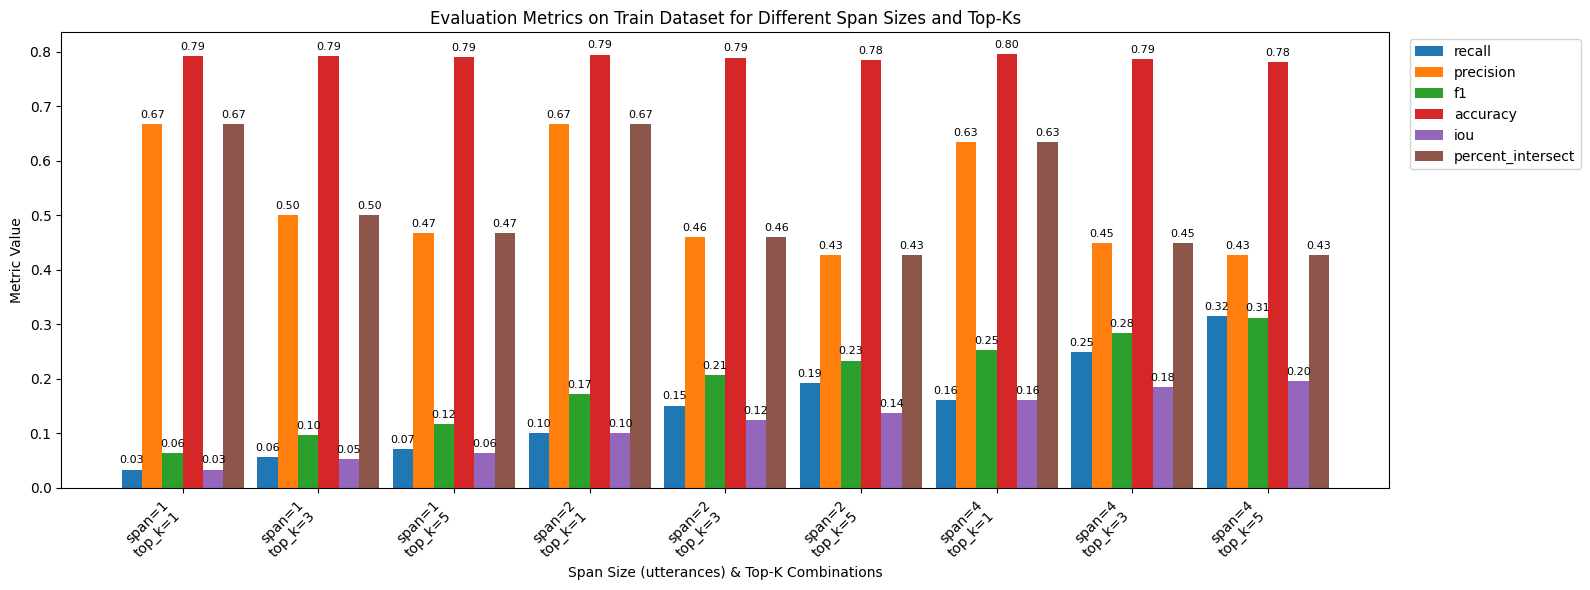

<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

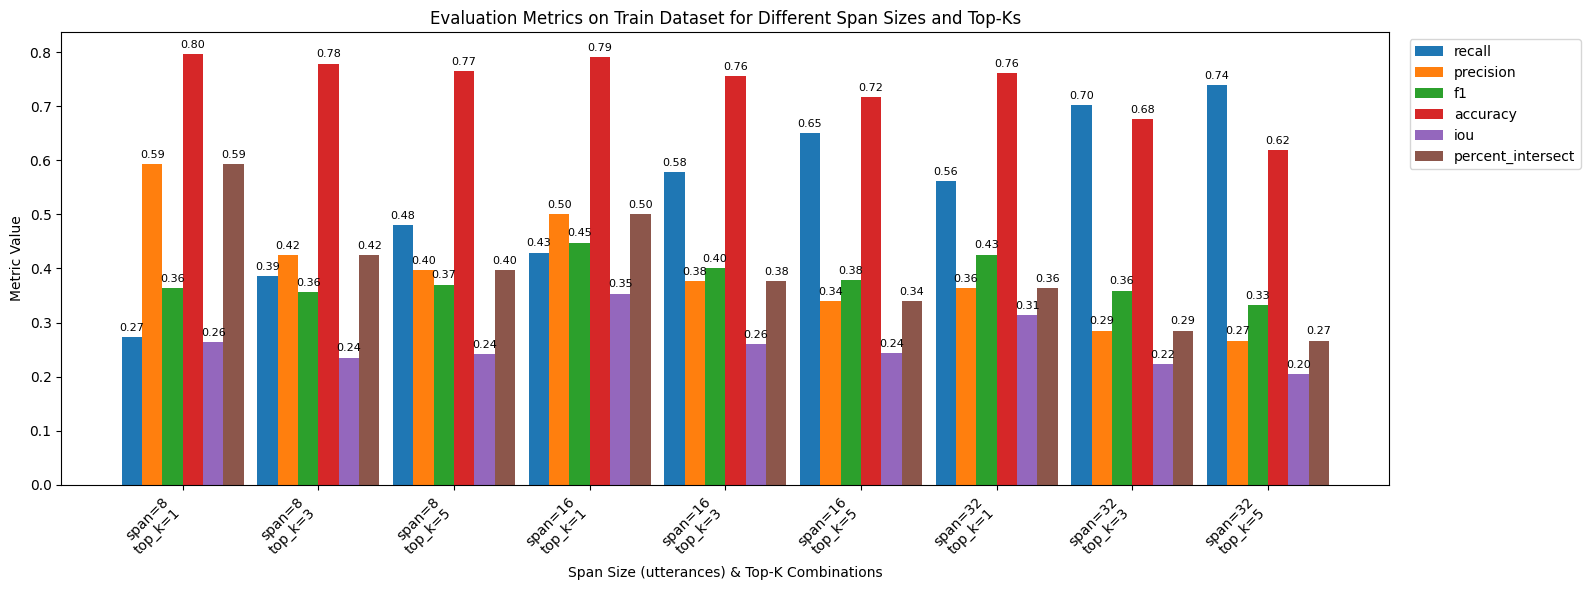

<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

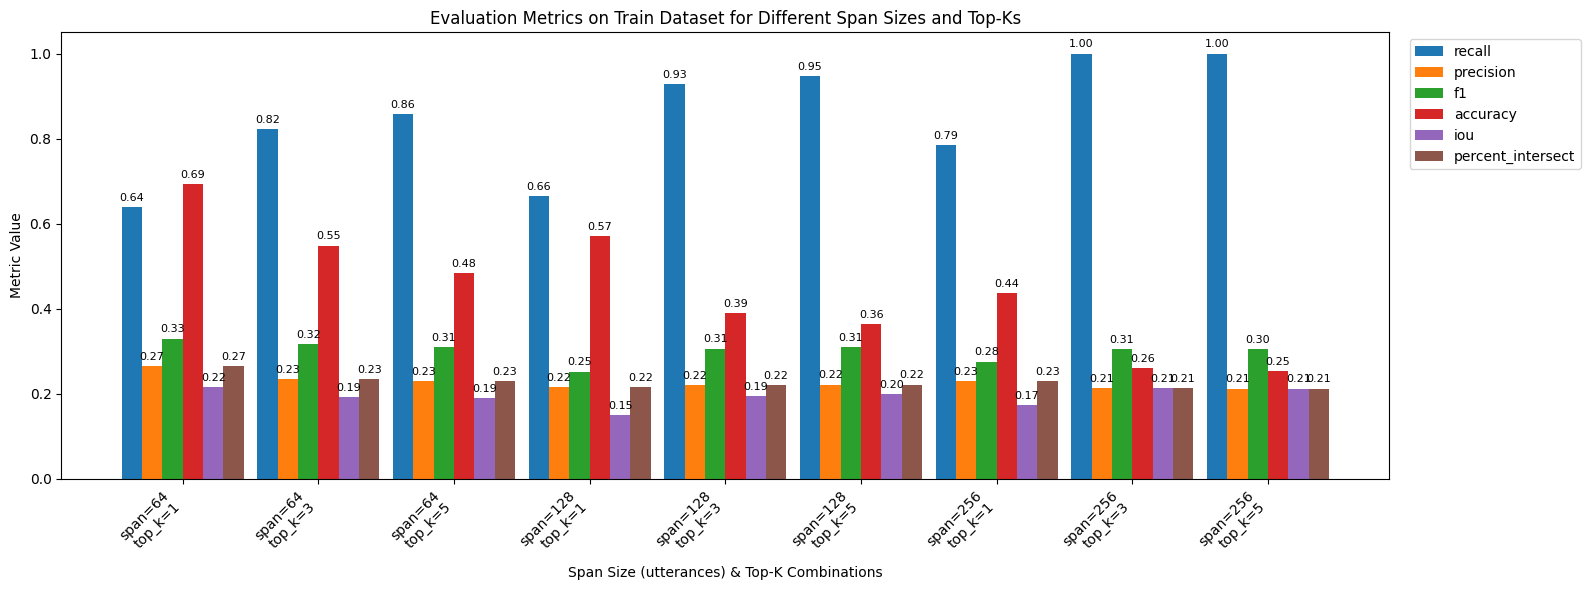

In [ ]:
plot_all_fix_span(train_dataset, "Train Dataset")

<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

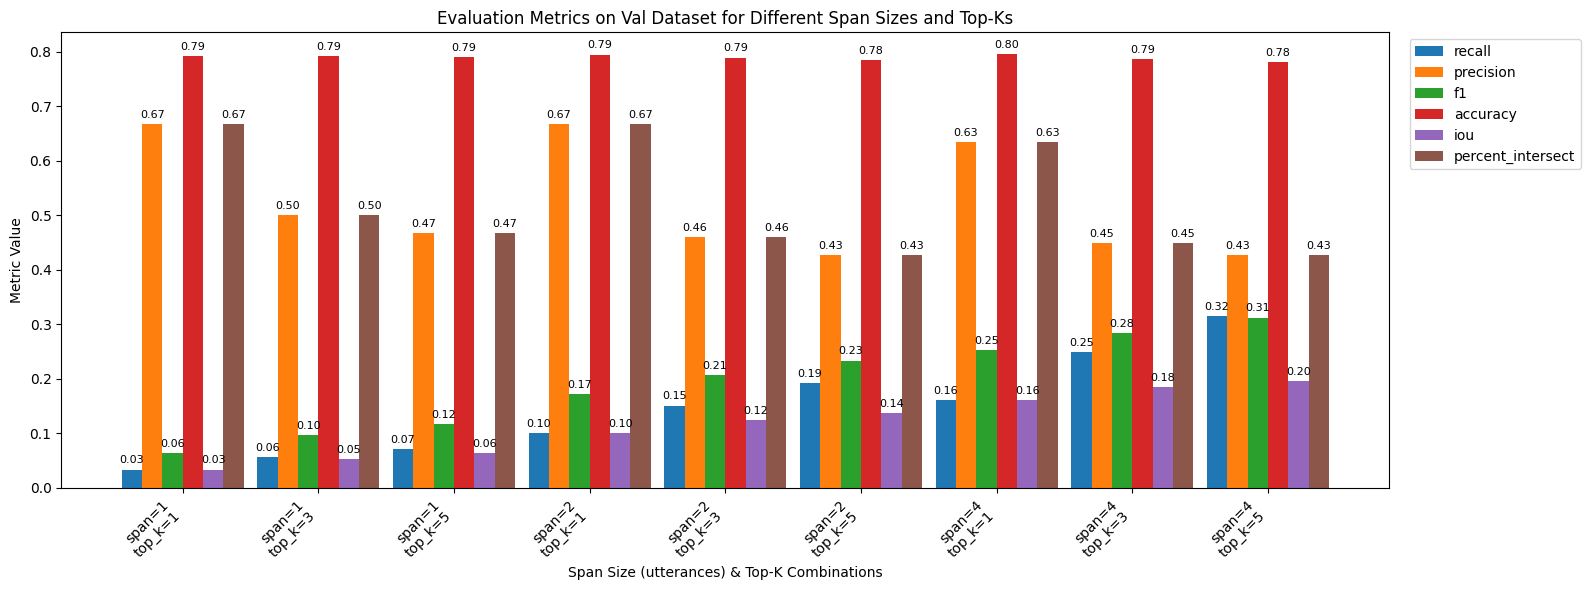

<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

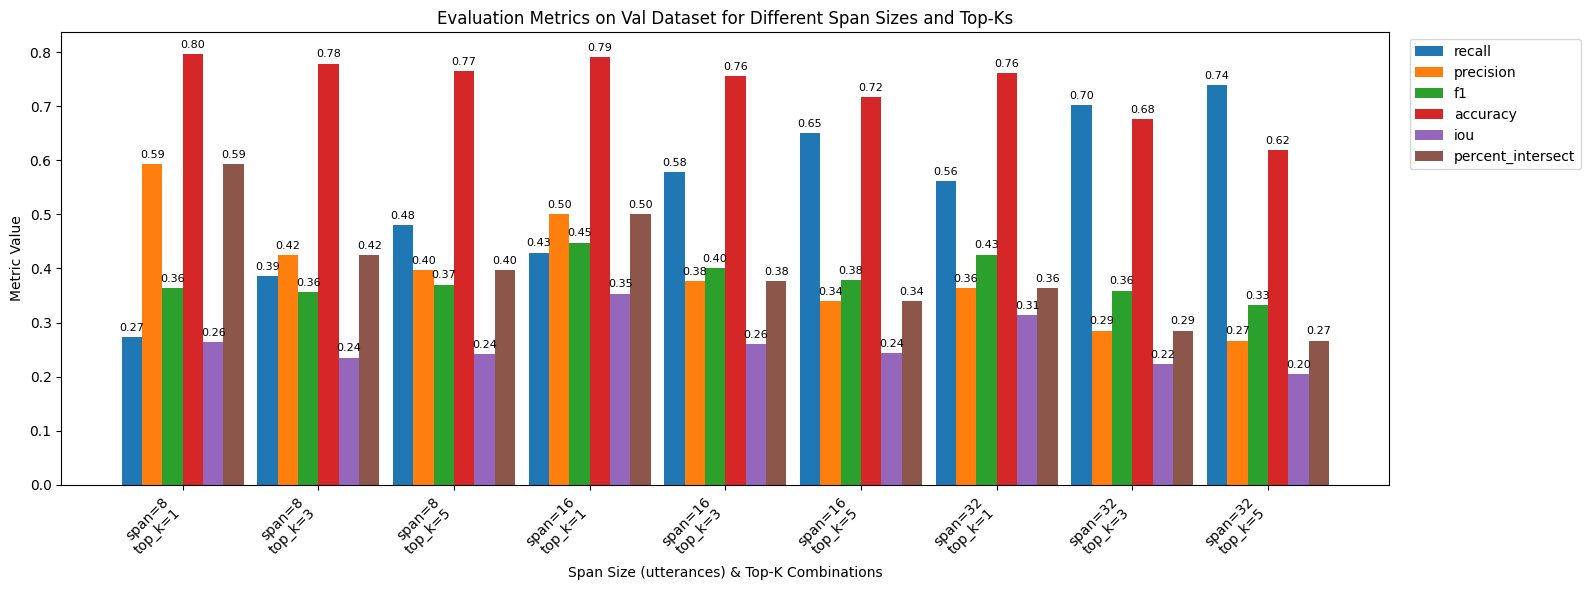

<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

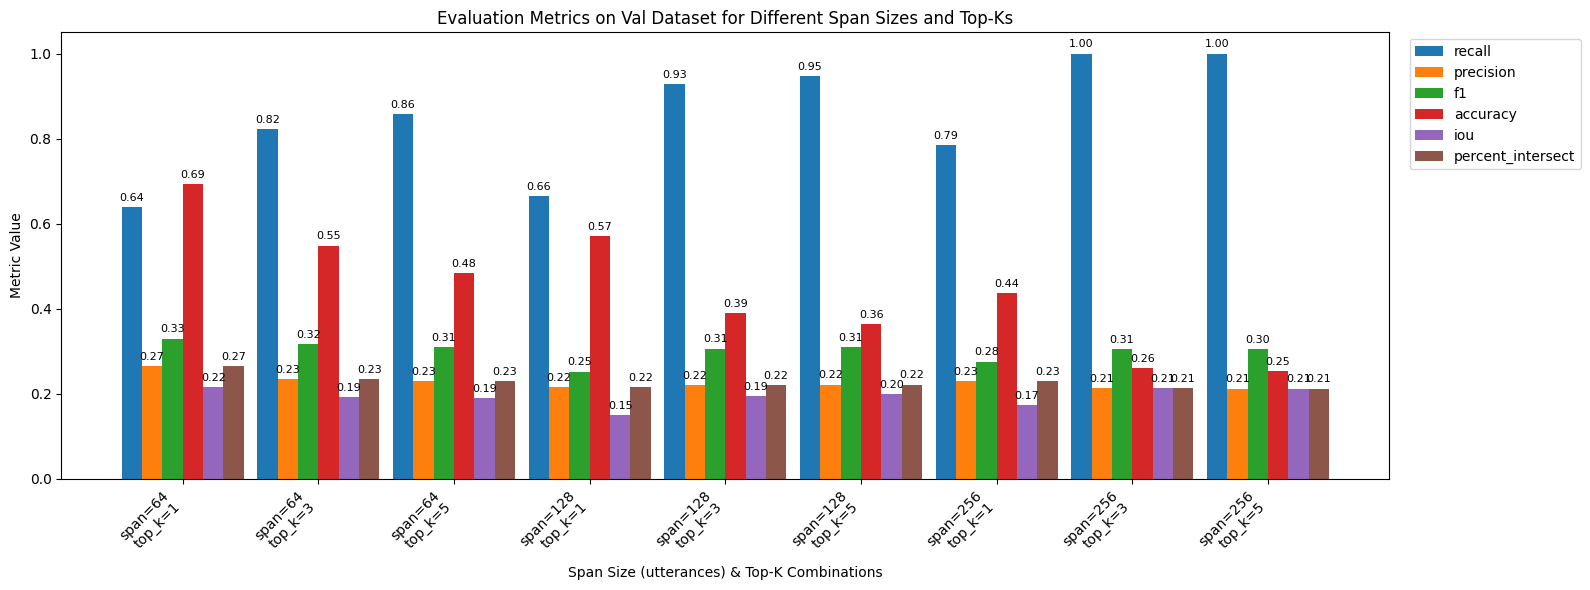

In [ ]:
plot_all_fix_span(val_dataset, "Val Dataset")

<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

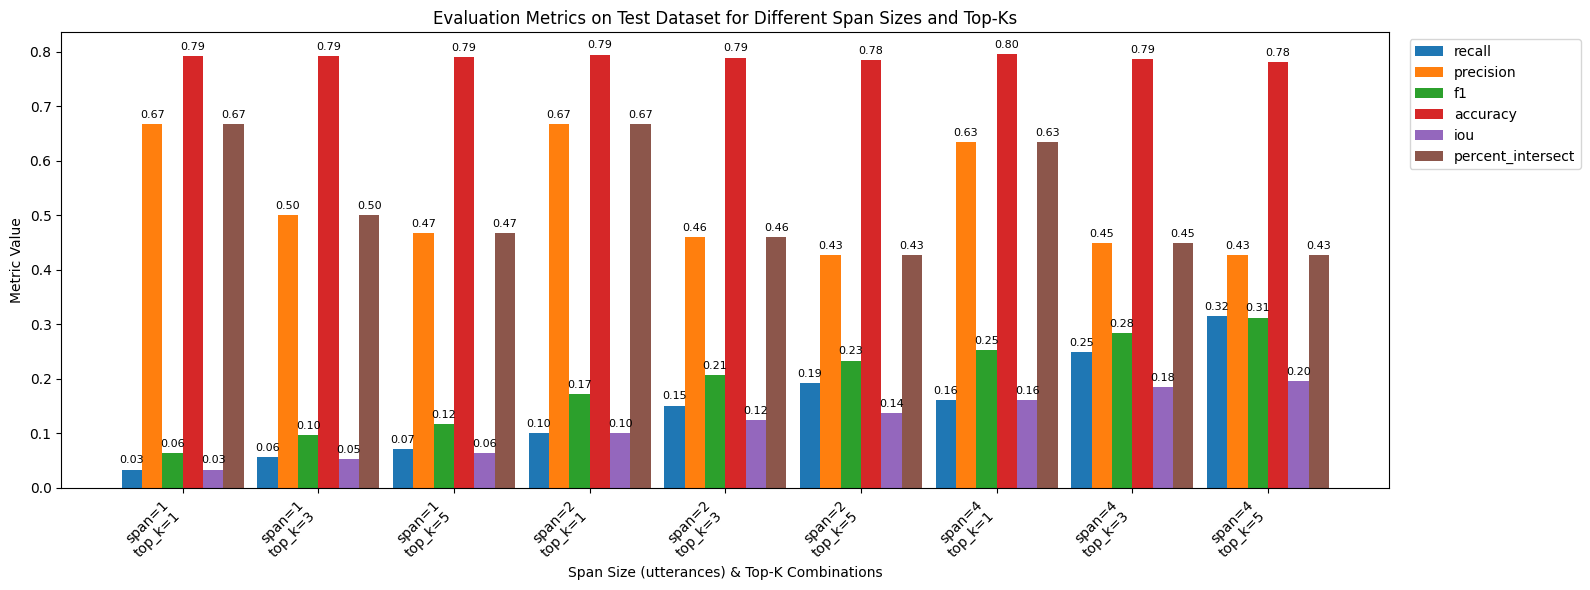

<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

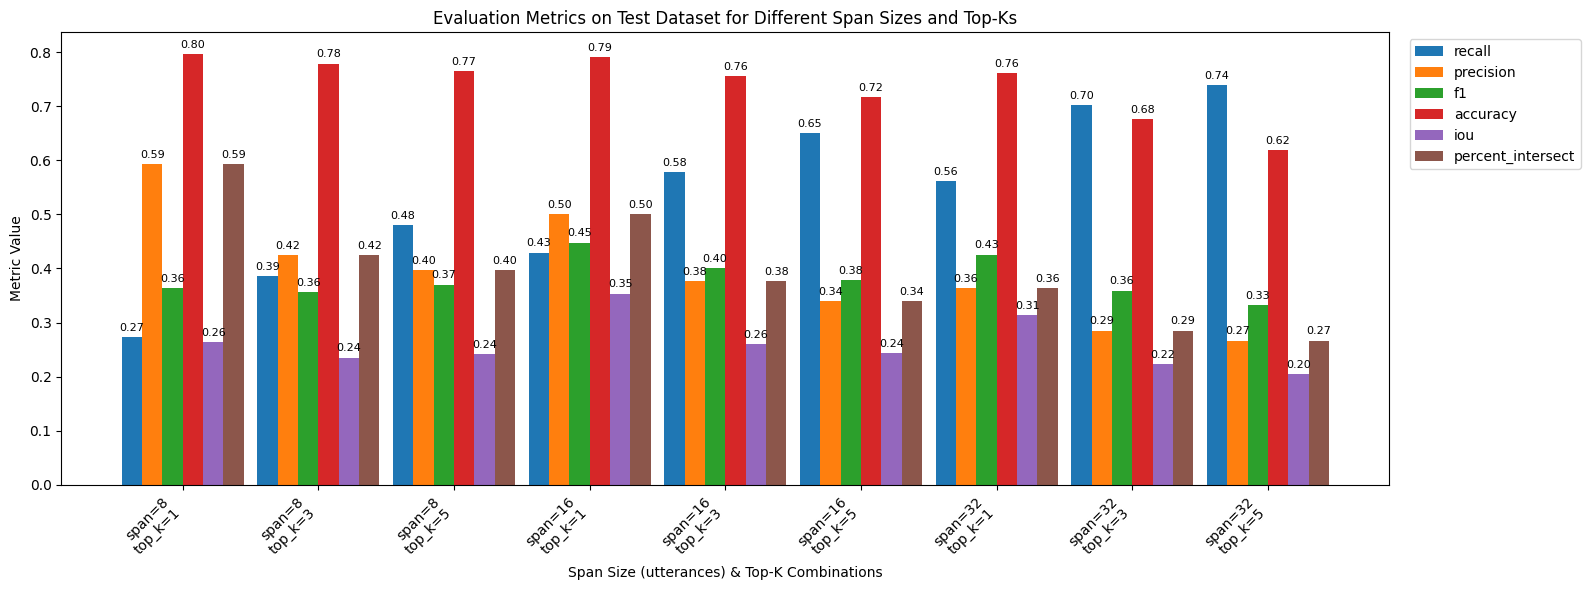

<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-26-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

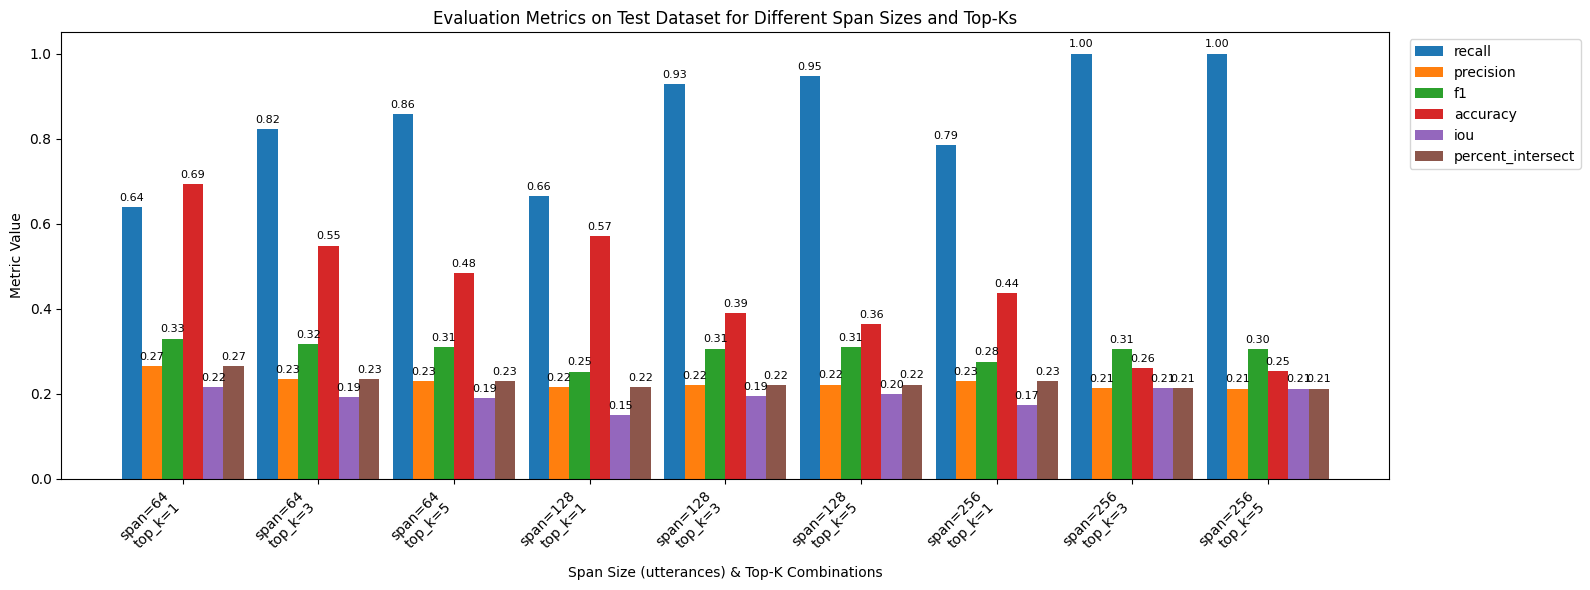

In [ ]:
plot_all_fix_span(test_dataset, "Test Dataset")

## Semantic chunk span

In [ ]:
!pip install semchunk
!pip install tiktoken transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.7 MB/s eta 0:00:00


In [ ]:
import semchunk

In [ ]:
def find_chunk_range_from_utt_index(chunk_ranges, utt_index):
    for start, end in chunk_ranges:
        if start <= utt_index <= end:
            return start, end

In [ ]:
def predict_labels_semantic_chunk_span(dataset, chunk_size, top_k=5):
  metrics = {
        'precision': [],
        'recall': [],
        'f1': [],
        'accuracy': [],
        'iou': [],
        'percent_intersect': []
    }

  chunker = semchunk.chunkerify('gpt-4', chunk_size=chunk_size)

  for item in dataset:
    utterances = item['utterances']
    questions = item['questions']

    #semantic chunking
    utterances_chunks = chunker("\n".join(utterances))
    chunk_ranges = []
    sentence_ind = 0
    for chunk in utterances_chunks:
      chunk_len = len(chunk.split("\n"))
      chunk_ranges.append((sentence_ind, sentence_ind + chunk_len - 1))

      sentence_ind += chunk_len

    for question in questions:
      scores = question['scores']
      labels = question['labels']

      scores_tensor = torch.tensor(scores)
      topk = torch.topk(scores_tensor, top_k)
      topk_indices = topk.indices.tolist()

      predicted_labels = [0] * len(utterances)
      for i in topk_indices:
        start, end = find_chunk_range_from_utt_index(chunk_ranges, i)
        for j in range(start, end):
                    predicted_labels[j] = 1

      # Compute metrics
      pred = torch.tensor(predicted_labels)
      true = torch.tensor(labels).int()

      intersection = (pred & true).sum().item()
      union = (pred | true).sum().item()
      total_pred_1 = pred.sum().item()

      precision = precision_score(true, pred, zero_division=0)
      recall = recall_score(true, pred, zero_division=0)
      f1 = f1_score(true, pred, zero_division=0)
      accuracy = accuracy_score(true, pred)
      iou = intersection / union if union > 0 else 0.0
      percent_intersect = intersection / total_pred_1 if total_pred_1 > 0 else 0.0

      metrics['precision'].append(precision)
      metrics['recall'].append(recall)
      metrics['f1'].append(f1)
      metrics['accuracy'].append(accuracy)
      metrics['iou'].append(iou)
      metrics['percent_intersect'].append(percent_intersect)

    # Average over all questions
    avg_metrics = {k: sum(v)/len(v) if len(v) > 0 else 0.0 for k, v in metrics.items()}
    return avg_metrics, metrics

In [ ]:
def plot_metrics_by_chunksize_and_topk(dataset, chunk_sizes: List[int], top_ks: List[int], dataset_name):
    import matplotlib.pyplot as plt
    import numpy as np

    metric_names = ['recall', 'precision', 'f1', 'accuracy', 'iou', 'percent_intersect']
    results = {metric: [] for metric in metric_names}
    labels = []

    for chunk_size in chunk_sizes:
        for top_k in top_ks:
            avg_metrics, _ = predict_labels_semantic_chunk_span(dataset, chunk_size, top_k)
            for metric in metric_names:
                results[metric].append(avg_metrics[metric])
            labels.append(f"chunk_size={chunk_size}\ntop_k={top_k}")

    x = np.arange(len(labels))
    width = 0.15

    # Plotting
    fig, ax = plt.subplots(figsize=(16, 6))
    for idx, metric in enumerate(metric_names):
        values = results[metric]
        bar_positions = x + idx * width
        bars = ax.bar(bar_positions, values, width, label=metric)
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset above the bar
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Chunk Size (tokens) & Top-K Combinations')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'Evaluation Metrics on {dataset_name} for Different Chunk Sizes and Top-Ks')
    ax.set_xticks(x + width * (len(metric_names) - 1) / 2)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_all_chunk_spans(dataset, dataset_name):
  #first plot
  chunk_sizes = [64, 128, 256]
  top_ks = [1, 3, 5]
  plot_metrics_by_chunksize_and_topk(train_dataset, chunk_sizes, top_ks, dataset_name)

  #second plot
  chunk_sizes = [512, 1024, 2048]
  top_ks = [1, 3, 5]
  plot_metrics_by_chunksize_and_topk(train_dataset, chunk_sizes, top_ks, dataset_name)

<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

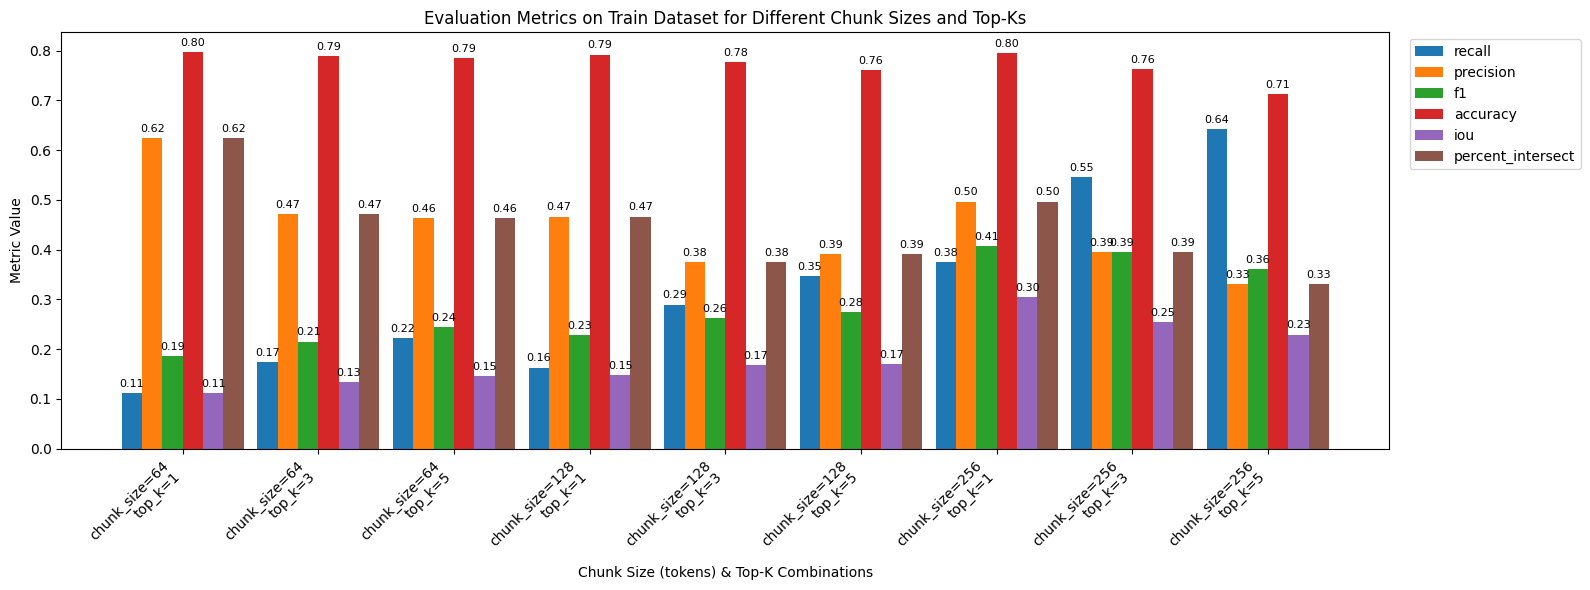

<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

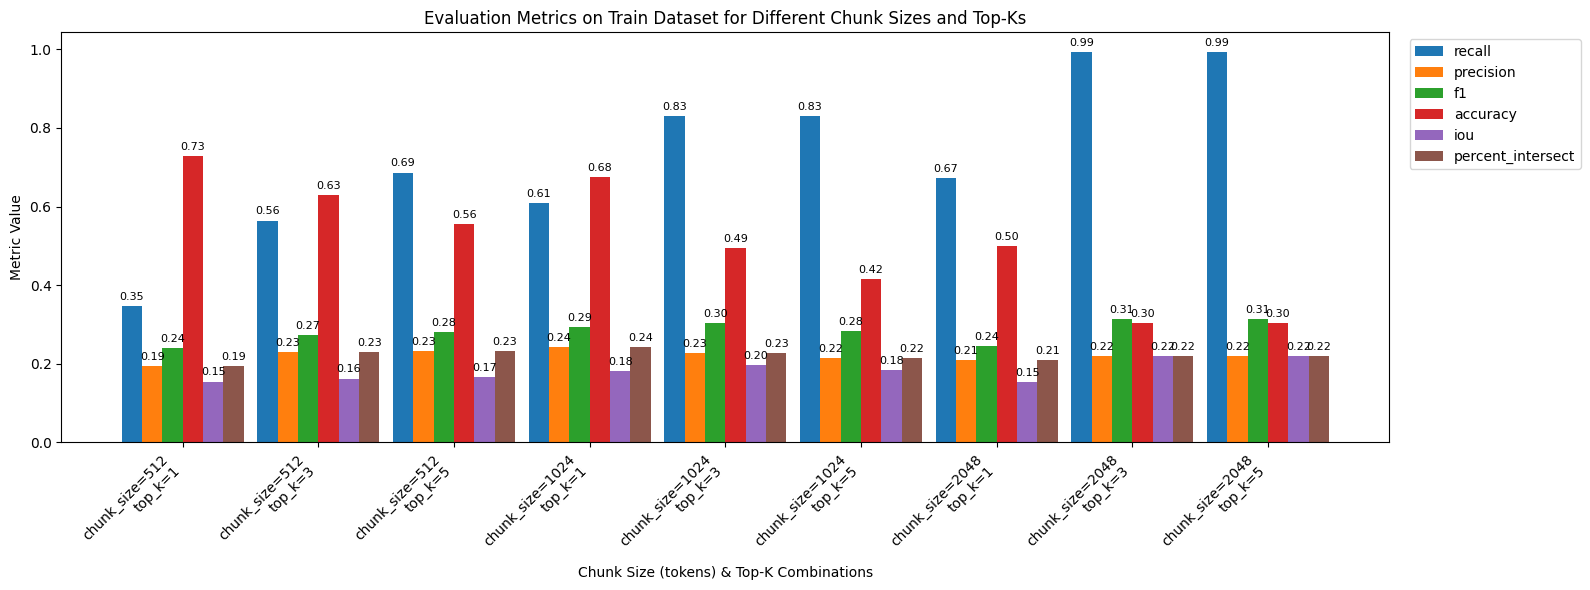

In [ ]:
plot_all_chunk_spans(train_dataset, "Train Dataset")

<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

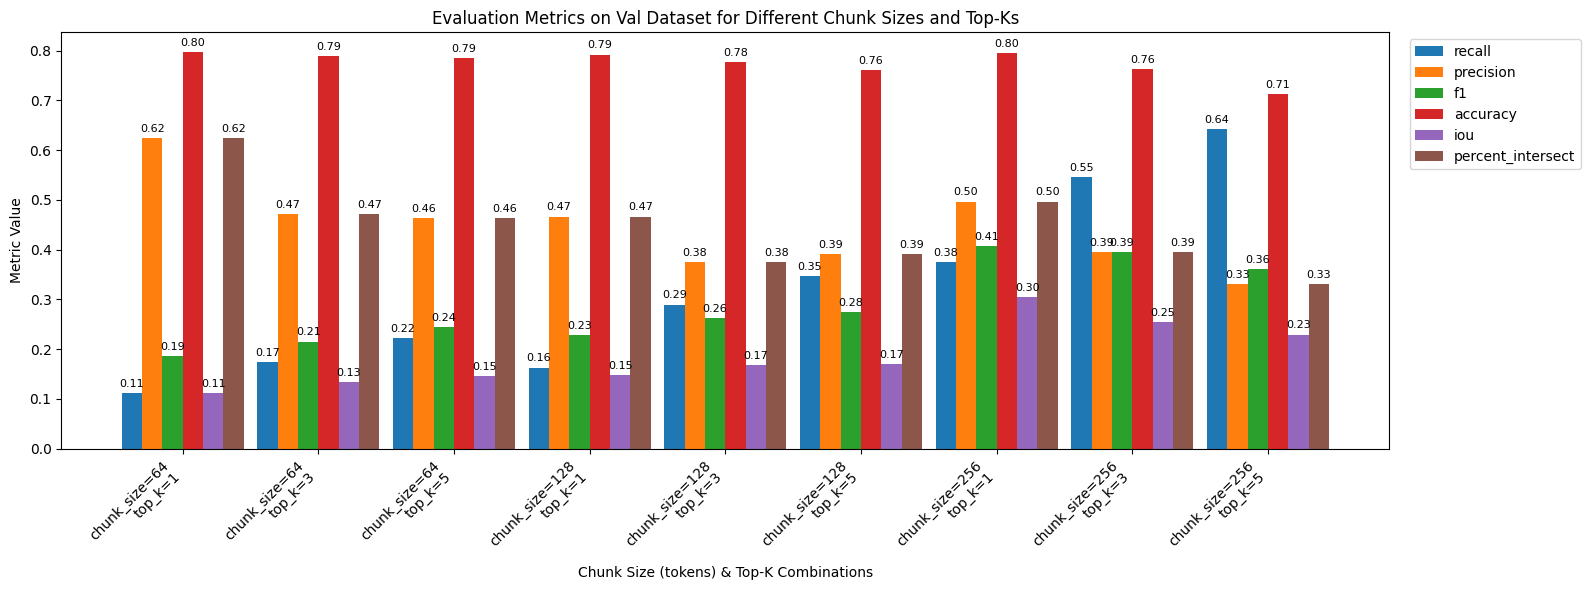

<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

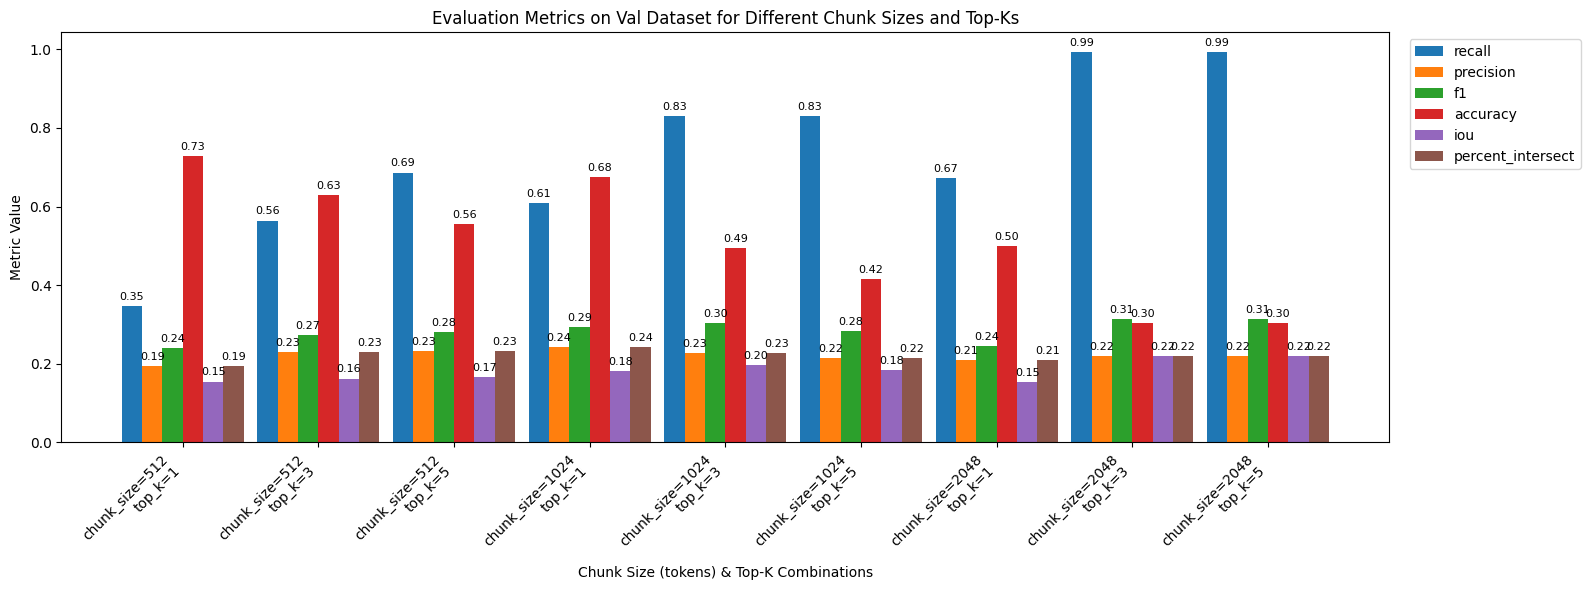

In [ ]:
plot_all_chunk_spans(val_dataset, "Val Dataset")

<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

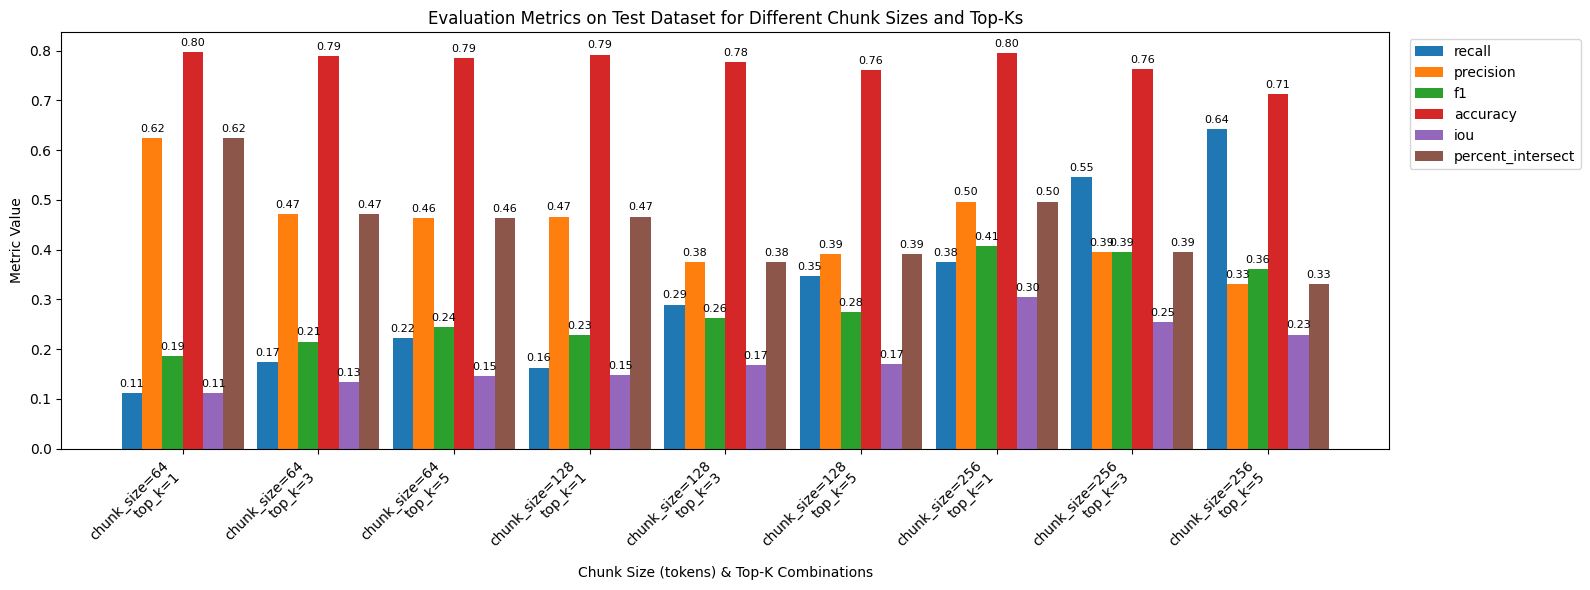

<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-51-20c2a41d731e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

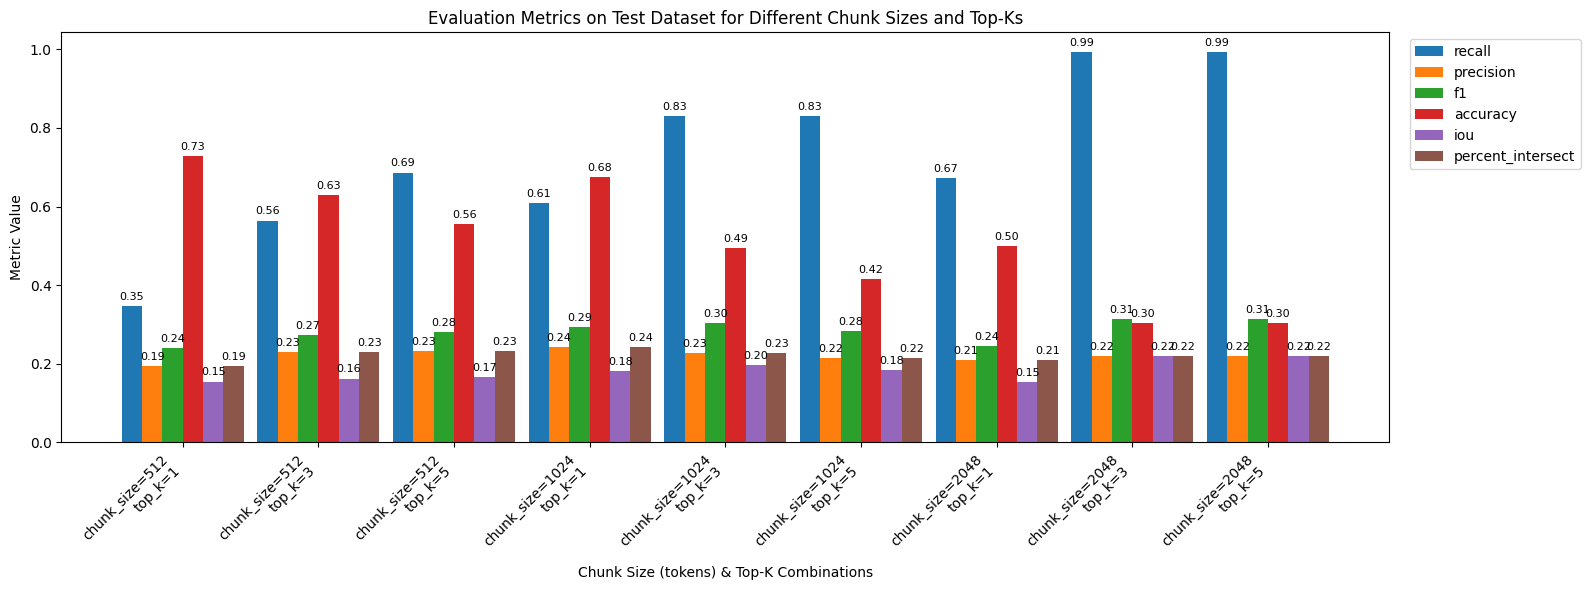

In [ ]:
plot_all_chunk_spans(test_dataset, "Test Dataset")

# Semantic Chunk + Cross Encoder Score Datasets

## Class Dataset

In [7]:
!pip install semchunk
!pip install tiktoken transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.8/272.8 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.4 MB/s eta 0:00:00


In [8]:
import semchunk

In [9]:
class ChunkCrossEncDatasets(Dataset):
    def __init__(self, json_files: List[str], encoder, chunk_size):
        self.data = []  # store each example here
        self.encoder = encoder
        self.chunk_size = chunk_size

        self.chunker = semchunk.chunkerify('gpt-4', chunk_size=chunk_size)

        for json_file in json_files:
            file_info = self._load_json(json_file)
            self.data.append(file_info)

    def _load_json(self, json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)

        # chunk and encode the utterances
        utterances = [f"{i} {t['speaker']}: {t['content']}" for i,t in enumerate(data['meeting_transcripts'])]
        utterances_chunks = self.chunker("\n".join(utterances))

        questions = []

        for item in data['specific_query_list']:
            query = item['query']
            answer = item['answer']

            spans = item['relevant_text_span']
            labels = [0] * len(utterances)

            for span in spans:
                start, end = int(span[0]), int(span[1])
                for i in range(start, end + 1):
                    labels[i] = 1

            labels = torch.tensor(labels, dtype=torch.float32)
            scores = self.score_utterances_chunks(query, utterances_chunks, len(utterances))

            questions.append({
                'query': query,
                'answer': answer,
                'scores': scores,
                'labels': labels,
            })

        file_info = {
            "utterances": utterances,
            "questions": questions
        }
        return file_info
    def score_utterances_chunks(self, query, utterances_chunks, utterance_length):
        scores = {}
        sentence_ind = 0
        for chunk in utterances_chunks:
          chunk_len = len(chunk.split("\n"))

          #score the chunk
          inputs = [(query, chunk)]
          chunk_score = self.encoder.predict(inputs)[0]
          end_ind = sentence_ind + chunk_len - 1
          if(end_ind > utterance_length - 1):
            break
          scores[(sentence_ind, end_ind)] = chunk_score
          sentence_ind = end_ind + 1

        return scores

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'utterances': item['utterances'],
            'questions': item['questions']
        }

In [10]:
def load_datasets(files, encoder, chunk_size):
  print("Datasets are loading...")
  train_dataset = ChunkCrossEncDatasets(files['train'], encoder, chunk_size)
  val_dataset = ChunkCrossEncDatasets(files['val'], encoder, chunk_size)
  test_dataset = ChunkCrossEncDatasets(files['test'], encoder, chunk_size)

  print(f"Train dataset size: {len(train_dataset)}")
  print(f"Validation dataset size: {len(val_dataset)}")
  print(f"Test dataset size: {len(test_dataset)}")
  return train_dataset, val_dataset, test_dataset

Note: The cross-encoder/ms-marco-MiniLM-L6-v2 model has a maximum token limit of 512

cross-encoder/ms-marco-MiniLM-L6-v2 uses the WordPiece tokenizer, which generally produces fewer tokens for the same text compared to GPT-4.

GPT-4 uses Byte Pair Encoding (BPE), specifically OpenAI's cl100k_base, which may result in more tokens for the same text.

As a rough estimate, 512 tokens in MiniLM could expand to around 600–900 tokens in GPT-4

In [11]:
from sentence_transformers import CrossEncoder
encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [ ]:
chunk_size = 512
train_dataset, val_dataset, test_dataset = load_datasets(files, encoder_model, chunk_size)

Datasets are loading...
Train dataset size: 162
Validation dataset size: 35
Test dataset size: 35


In [ ]:
print(test_dataset[-1]["questions"][-1]["scores"])

{(0, 33): np.float32(-11.051589), (34, 42): np.float32(-11.362079), (43, 63): np.float32(-11.409817), (64, 85): np.float32(-11.399874), (86, 109): np.float32(-11.375973), (110, 134): np.float32(-11.376312), (135, 160): np.float32(-11.313882), (161, 188): np.float32(-11.3216305), (189, 202): np.float32(-11.409795), (203, 216): np.float32(-11.4053135), (217, 237): np.float32(-11.0475235), (238, 264): np.float32(-11.367102), (265, 291): np.float32(-11.350068), (292, 317): np.float32(-11.32584), (318, 339): np.float32(-11.350475), (340, 362): np.float32(-10.9516), (363, 386): np.float32(-11.419079), (387, 410): np.float32(-8.62395), (411, 436): np.float32(-10.014284), (437, 466): np.float32(-11.212066), (467, 497): np.float32(-11.402202), (498, 517): np.float32(-11.3215885), (518, 545): np.float32(-11.136667), (546, 572): np.float32(-10.118586), (573, 603): np.float32(-10.235544)}


### Score Analysis

In [ ]:
def plot_scores_chunk_dataset(dataset, data_idx, question_idx):
    question = train_dataset[data_idx]['questions'][question_idx]
    scores = question['scores']
    labels = question['labels']

    scores = scores.detach().cpu().numpy() if hasattr(scores, "detach") else scores
    labels = labels.detach().cpu().numpy() if hasattr(labels, "detach") else labels

    scores_list = [0] * len(labels)
    for chunk_range, score in scores.items():
      start, end = chunk_range
      for i in range(start, end + 1):
        scores_list[i] = score

    x = list(range(len(scores_list)))
    colors = ['green' if label == 1 else 'red' for label in labels]

    plt.figure(figsize=(12, 6))
    plt.scatter(x, scores_list, c=colors)
    plt.xlabel("Utterance Index")
    plt.ylabel("Relevance Score")
    plt.title(f"Utterance Relevance Scores")
    plt.grid(True)
    plt.show()


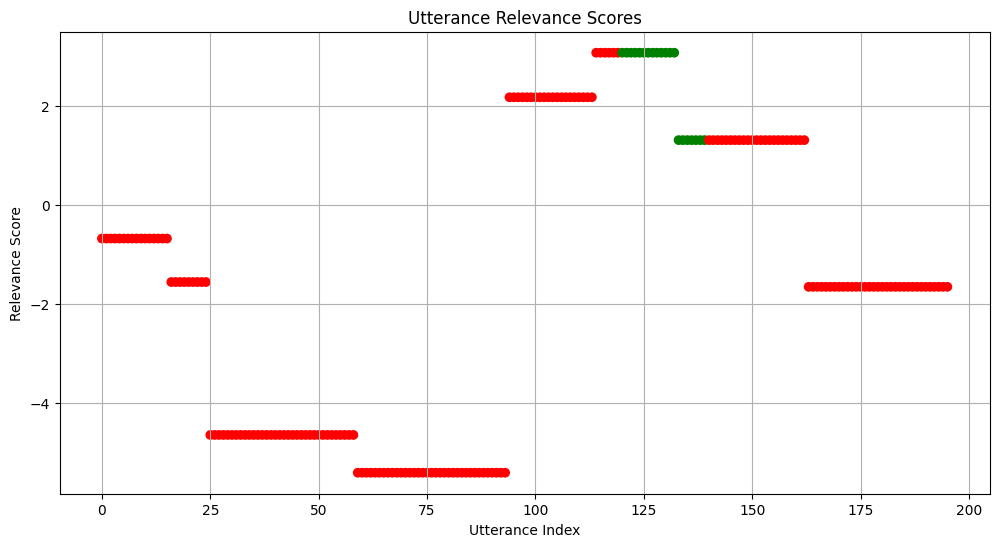

In [ ]:
plot_scores_chunk_dataset(train_dataset, 20, 0)

## Top-k chunks retrieval

In [ ]:
def predict_labels_semantic_chunk_span_cross_enc(dataset, top_k=5):
  metrics = {
        'precision': [],
        'recall': [],
        'f1': [],
        'accuracy': [],
        'iou': [],
        'percent_intersect': []
    }

  for item in dataset:
    utterances = item['utterances']
    questions = item['questions']
    for question in questions:
      scores = question['scores']
      labels = question['labels']

      top_k_chunks = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
      top_k_chunk_ranges = [chunk_range for chunk_range, score in top_k_chunks]

      predicted_labels = [0] * len(utterances)
      for start, end in top_k_chunk_ranges:
        for j in range(start, end):
                    predicted_labels[j] = 1

      # Compute metrics
      pred = torch.tensor(predicted_labels)
      true = torch.tensor(labels).int()

      intersection = (pred & true).sum().item()
      union = (pred | true).sum().item()
      total_pred_1 = pred.sum().item()

      precision = precision_score(true, pred, zero_division=0)
      recall = recall_score(true, pred, zero_division=0)
      f1 = f1_score(true, pred, zero_division=0)
      accuracy = accuracy_score(true, pred)
      iou = intersection / union if union > 0 else 0.0
      percent_intersect = intersection / total_pred_1 if total_pred_1 > 0 else 0.0

      metrics['precision'].append(precision)
      metrics['recall'].append(recall)
      metrics['f1'].append(f1)
      metrics['accuracy'].append(accuracy)
      metrics['iou'].append(iou)
      metrics['percent_intersect'].append(percent_intersect)

    # Average over all questions
    avg_metrics = {k: sum(v)/len(v) if len(v) > 0 else 0.0 for k, v in metrics.items()}
    return avg_metrics, metrics

In [ ]:
def plot_chunk_metrics_by_chunksize_and_topk_on_test(files, encoder_model, chunk_sizes: List[int], top_ks: List[int], dataset_name='Test Dataset'):
    import matplotlib.pyplot as plt
    import numpy as np

    metric_names = ['recall', 'precision', 'f1', 'accuracy', 'iou', 'percent_intersect']
    results = {metric: [] for metric in metric_names}
    labels = []

    for chunk_size in chunk_sizes:
        print("Test Dataset is loading ...")
        test_dataset = ChunkCrossEncDatasets(files['test'], encoder_model, chunk_size)
        for top_k in top_ks:
            avg_metrics, _ = predict_labels_semantic_chunk_span_cross_enc(test_dataset, top_k)
            for metric in metric_names:
                results[metric].append(avg_metrics[metric])
            labels.append(f"chunk_size={chunk_size}\ntop_k={top_k}")

    x = np.arange(len(labels))
    width = 0.15

    # Plotting
    fig, ax = plt.subplots(figsize=(16, 6))
    for idx, metric in enumerate(metric_names):
        values = results[metric]
        bar_positions = x + idx * width
        bars = ax.bar(bar_positions, values, width, label=metric)
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset above the bar
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Chunk Size (tokens) & Top-K Combinations')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'Evaluation Metrics on {dataset_name} for Different Chunk Sizes and Top-Ks (Chunked Dataset)')
    ax.set_xticks(x + width * (len(metric_names) - 1) / 2)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    plt.tight_layout()
    plt.show()


Test Dataset is loading ...


<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

Test Dataset is loading ...


<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

Test Dataset is loading ...


<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

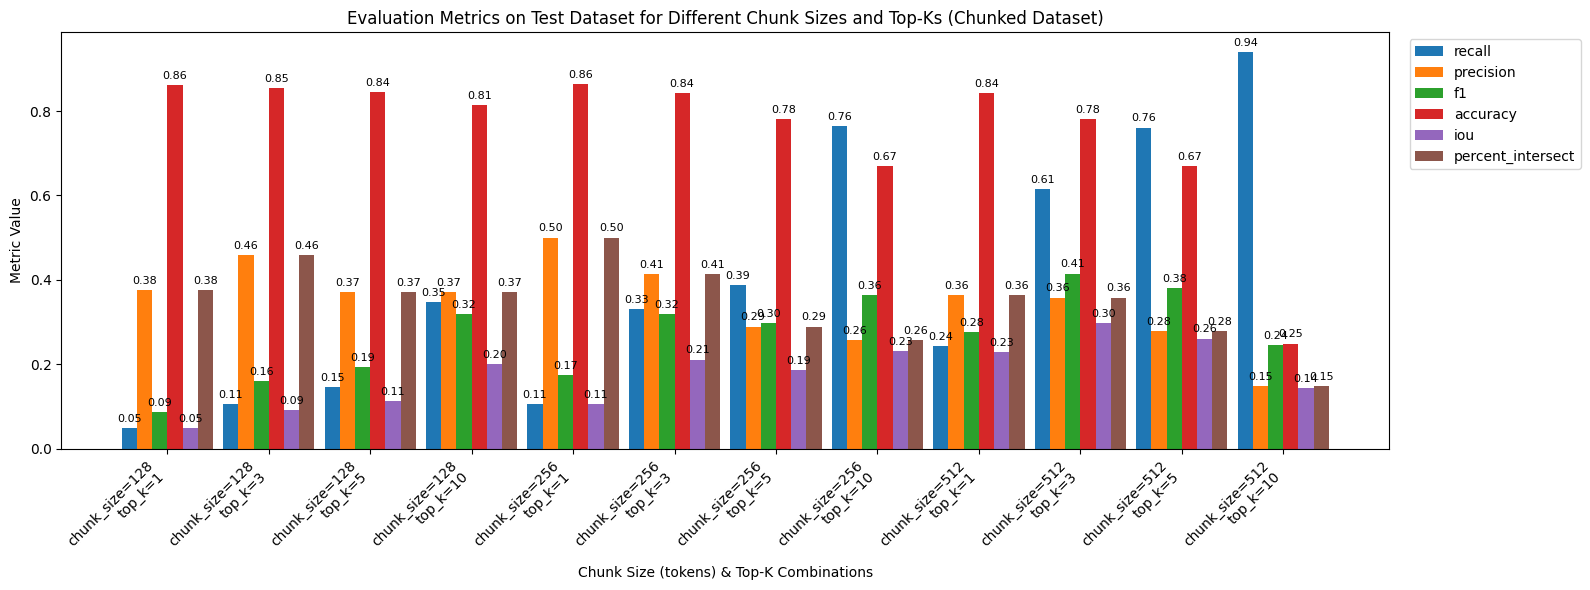

In [ ]:
chunk_sizes = [128, 256, 512]
top_ks = [1, 3, 5, 10]
plot_chunk_metrics_by_chunksize_and_topk_on_test(files, encoder_model, chunk_sizes, top_ks, dataset_name='Test Dataset')

In [ ]:
avg_metrics, metrics = predict_labels_semantic_chunk_span_cross_enc(train_dataset, top_k=5)

<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-21-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

In [ ]:
print(avg_metrics)

{'precision': 0.2357654375573631, 'recall': 0.8615435737401755, 'f1': 0.31522726264288453, 'accuracy': 0.48500000000000004, 'iou': 0.19686443779707075, 'percent_intersect': 0.2357654375573631}


## Save prediction of the best RAG
Best RAG: Semantic chunk encoded with chunk size = 512 tokens, top-k = 3

In [12]:
class ChunkCrossEncExportDatasets(Dataset):
    def __init__(self, json_files: List[str], encoder, chunk_size):
        self.data = []  # store each example here
        self.encoder = encoder
        self.chunk_size = chunk_size

        self.chunker = semchunk.chunkerify('gpt-4', chunk_size=chunk_size)

        for json_file in json_files:
            file_info = self._load_json(json_file)
            self.data.append(file_info)

    def _load_json(self, json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)

        # chunk and encode the utterances
        utterances = [f"{t['speaker']}: {t['content']}" for i,t in enumerate(data['meeting_transcripts'])]
        utterances_chunks = self.chunker("\n".join(utterances))

        questions = []

        for item in data['specific_query_list']:
            query = item['query']
            answer = item['answer']

            spans = item['relevant_text_span']
            labels = [0] * len(utterances)

            for span in spans:
                start, end = int(span[0]), int(span[1])
                for i in range(start, end + 1):
                    labels[i] = 1

            labels = torch.tensor(labels, dtype=torch.float32)
            scores = self.score_utterances_chunks(query, utterances_chunks, len(utterances))

            questions.append({
                'query': query,
                'answer': answer,
                'scores': scores,
                'labels': labels,
            })

        file_info = {
            "utterances": utterances,
            "questions": questions
        }
        return file_info
    def score_utterances_chunks(self, query, utterances_chunks, utterance_length):
        scores = {}
        sentence_ind = 0
        for chunk in utterances_chunks:
          chunk_len = len(chunk.split("\n"))

          #score the chunk
          inputs = [(query, chunk)]
          chunk_score = self.encoder.predict(inputs)[0]
          end_ind = sentence_ind + chunk_len - 1
          if(end_ind > utterance_length - 1):
            break
          scores[(sentence_ind, end_ind)] = chunk_score
          sentence_ind = end_ind + 1

        return scores

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'utterances': item['utterances'],
            'questions': item['questions']
        }

In [13]:
def load_export_datasets(files, encoder, chunk_size):
  print("Datasets are loading...")
  train_dataset = ChunkCrossEncExportDatasets(files['train'], encoder, chunk_size)
  val_dataset = ChunkCrossEncExportDatasets(files['val'], encoder, chunk_size)
  test_dataset = ChunkCrossEncExportDatasets(files['test'], encoder, chunk_size)

  print(f"Train dataset size: {len(train_dataset)}")
  print(f"Validation dataset size: {len(val_dataset)}")
  print(f"Test dataset size: {len(test_dataset)}")
  return train_dataset, val_dataset, test_dataset

In [14]:
import json
def save_prediction(dataset, result_save_path, top_k):
  result_json = {
      "files": []
  }
  for item in dataset:
      utterances = item['utterances']
      questions = item['questions']
      save_questions = []
      for question in questions:
          query = question['query']
          answer = question['answer']
          scores = question['scores']
          labels = question['labels']

          top_k_chunks = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
          top_k_chunk_ranges = [chunk_range for chunk_range, score in top_k_chunks]

          predicted_labels = [0] * len(utterances)
          for start, end in top_k_chunk_ranges:
            for j in range(start, end):
                        predicted_labels[j] = 1

          save_questions.append({
              "query": query,
              "answer": answer,
              "predicted_labels": predicted_labels,
              "labels": labels.tolist()
          })

      result_json['files'].append({
          'utterances': utterances,
          'questions': save_questions
      })

  #save
  with open(result_save_path, 'w') as f:
    json.dump(result_json, f)

  return result_json

In [15]:
chunk_size = 512
train_dataset, val_dataset, test_dataset = load_export_datasets(files, encoder_model, chunk_size)

Datasets are loading...
Train dataset size: 162
Validation dataset size: 35
Test dataset size: 35


In [16]:
print(train_dataset[0]['questions'][0]['labels'])

tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [19]:
train_results = save_prediction(train_dataset, "/content/train_pred.json", top_k=3)
val_results = save_prediction(val_dataset, "/content/val_pred.json", top_k=3)
test_results = save_prediction(test_dataset, "/content/test_pred.json", top_k=3)

In [21]:
print(len(train_results['files']))
print(len(val_results['files']))
print(len(test_results['files']))

162
35
35


In [18]:
print(train_dataset[0]['questions'][0]['answer'])

The marketing expert confirmed with the group that the product was aimed at people with age below forty, but it  was also designed for people above forty. The marketing expert also stated that people would need a teletext button because it was originally combined with the menu in the prototype. After that, the marketing expert discussed with the designers to design the prototype with fresh colours so it would be more discoverable when lost. They also agreed on the button numbers and the texture.


# Fine-tune cross-encoder
fine-tune cross-encoder/ms-marco-MiniLM-L6-v2 with chunk size = 512 tokens

## Class Dataset

In [ ]:
class FineTuneDatasets(Dataset):
    def __init__(self, json_files: List[str], chunk_size):
        self.data = []  # store each example here
        self.chunk_size = chunk_size

        self.chunker = semchunk.chunkerify('gpt-4', chunk_size=chunk_size)

        for json_file in json_files:
            questions = self._load_json(json_file)
            self.data.extend(questions)

    def _load_json(self, json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)

        # chunk and encode the utterances
        utterances = [f"{i} {t['speaker']}: {t['content']}" for i,t in enumerate(data['meeting_transcripts'])]
        utterances_chunks = self.chunker("\n".join(utterances))

        questions = []

        for item in data['specific_query_list']:
            query = item['query']

            spans = item['relevant_text_span']
            labels = [0] * len(utterances)

            for span in spans:
                start, end = int(span[0]), int(span[1])
                for i in range(start, end + 1):
                    labels[i] = 1

            labels = torch.tensor(labels, dtype=torch.float32)
            scores = self.score_utterances_chunks(labels, utterances_chunks, len(utterances))

            questions.append({
                'query': query,
                "utterances_chunks": utterances_chunks,
                'scores': scores
            })
        return questions

    def score_utterances_chunks(self, labels, utterances_chunks, utterance_length):
        scores = []
        sentence_ind = 0
        for chunk in utterances_chunks:
          chunk_len = len(chunk.split("\n"))

          #score the chunk
          end_ind = sentence_ind + chunk_len - 1
          if(end_ind > utterance_length - 1):
            break
          chunk_label = labels[sentence_ind:end_ind + 1]
          chunk_score = sum(chunk_label) / len(chunk_label) #score the chunk based on mean
          scores.append(chunk_score)
          sentence_ind = end_ind + 1

        return scores

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'query': item['query'],
            'utterances_chunks': item['utterances_chunks'],
            'scores': item['scores']
        }

In [ ]:
!pip install transformers torch tqdm sentence-transformers semchunk

In [ ]:
import json
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.nn import MSELoss
from tqdm.notebook import tqdm
import os
from typing import List
import semchunk
from google.colab import drive
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

GPU available: True
GPU name: Tesla T4


In [ ]:
class FineTuneDatasets(Dataset):
    def __init__(self, json_files: List[str], chunk_size):
        self.data = []  # store each example here
        self.chunk_size = chunk_size

        self.chunker = semchunk.chunkerify('gpt-4', chunk_size=chunk_size)

        for json_file in json_files:
            questions = self._load_json(json_file)
            self.data.extend(questions)

    def _load_json(self, json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)

        # chunk and encode the utterances
        utterances = [f"{i} {t['speaker']}: {t['content']}" for i,t in enumerate(data['meeting_transcripts'])]
        utterances_chunks = self.chunker("\n".join(utterances))

        questions = []

        for item in data['specific_query_list']:
            query = item['query']

            spans = item['relevant_text_span']
            labels = [0] * len(utterances)

            for span in spans:
                start, end = int(span[0]), int(span[1])
                for i in range(start, end + 1):
                    labels[i] = 1

            labels = torch.tensor(labels, dtype=torch.float32)
            filtered_chunks = self.score_utterances_chunks(labels, utterances_chunks, len(utterances))

            for chunk_info in filtered_chunks:
              chunk, score = chunk_info

              questions.append({
                  'input': [query, chunk],
                  'score': score
              })
        return questions

    def score_utterances_chunks(self, labels, utterances_chunks, utterance_length):
        scores = []
        sentence_ind = 0
        filtered_chunks = []

        for chunk in utterances_chunks:
          chunk_len = len(chunk.split("\n"))

          #score the chunk
          end_ind = sentence_ind + chunk_len - 1
          if(end_ind > utterance_length - 1):
            break
          chunk_label = labels[sentence_ind:end_ind + 1]
          chunk_score = sum(chunk_label) / len(chunk_label) #score the chunk based on mean

          filtered_chunks.append((chunk, chunk_score))

          sentence_ind = end_ind + 1

        return filtered_chunks

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'input': item['input'],
            'score': item['score']
        }

## FineTuner

In [ ]:
class CrossEncoderFineTuner:
    def __init__(self, model_name="cross-encoder/ms-marco-MiniLM-L6-v2", max_length=512):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.model.to(self.device)

        self.max_length = max_length
        self.training_stats = {
            'train_loss': [],
            'val_loss': []
        }

    def prepare_batch(self, batch):
        query = batch['query']
        answer = batch['answer']
        score = batch['score']

        all_inputs = []
        all_scores = []



        for idx, query in enumerate(queries):
            for chunk_idx, chunk in enumerate(utterances_chunks[idx]):
                all_inputs.append((query, chunk))
                all_scores.append(scores[idx][chunk_idx])

        inputs = self.tokenizer(
            [(query, chunk) for query, chunk in all_inputs],
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        labels = torch.tensor(all_scores, dtype=torch.float).to(self.device)

        return inputs, labels

    def train(self, train_dataset, val_dataset=None, batch_size=8, epochs=3, learning_rate=2e-5):
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        if val_dataset:
            val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

        # Setup optimizer and scheduler
        optimizer = AdamW(self.model.parameters(), lr=learning_rate)

        total_steps = len(train_dataloader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0.1*total_steps,
            num_training_steps=total_steps
        )

        criterion = MSELoss()

        best_val_loss = float('inf')

        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")

            # Training
            self.model.train()
            train_loss = 0

            train_progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}")
            for batch in train_progress_bar:
                # Prepare batch data
                flat_inputs_dict, flat_labels = self.prepare_batch(batch)

                optimizer.zero_grad()

                outputs = self.model(**flat_inputs_dict)
                logits = outputs.logits.squeeze(-1)  # Shape: (batch_size,)

                loss = criterion(logits, flat_labels)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

                optimizer.step()
                scheduler.step()

                train_loss += loss.item()
                train_progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

            avg_train_loss = train_loss / len(train_dataloader)
            self.training_stats['train_loss'].append(avg_train_loss)
            print(f"Average training loss: {avg_train_loss:.4f}")

            # Validation
            if val_dataset:
                self.model.eval()
                val_loss = 0

                with torch.no_grad():
                    val_progress_bar = tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}")
                    for batch in val_progress_bar:
                        # Prepare batch data
                        flat_inputs_dict, flat_labels = self.prepare_batch(batch)

                        outputs = self.model(**flat_inputs_dict)
                        logits = outputs.logits.squeeze(-1)

                        loss = criterion(logits, flat_labels)
                        val_loss += loss.item()
                        val_progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

                avg_val_loss = val_loss / len(val_dataloader)
                self.training_stats['val_loss'].append(avg_val_loss)
                print(f"Average validation loss: {avg_val_loss:.4f}")

                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    print("Saving best model...")
                    self.save_model("/content/drive/MyDrive/cross_encoder_best_model")

        # Save the final model
        self.save_model("/content/drive/MyDrive/cross_encoder_final_model")

        # Plot training stats
        self.plot_training_stats()

        return self.model, self.tokenizer

    def plot_training_stats(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.training_stats['train_loss'], label='Training Loss')
        if self.training_stats['val_loss']:
            plt.plot(self.training_stats['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('/content/drive/MyDrive/training_loss.png')
        plt.show()

    def save_model(self, path):
        os.makedirs(path, exist_ok=True)
        self.model.save_pretrained(path)
        self.tokenizer.save_pretrained(path)
        print(f"Model saved to {path}")

    def load_model(self, path):
        self.model = AutoModelForSequenceClassification.from_pretrained(path)
        self.tokenizer = AutoTokenizer.from_pretrained(path)
        self.model.to(self.device)
        print(f"Model loaded from {path}")



In [ ]:
# Function for testing model predictions
def predict(query, chunk, model, tokenizer, device):
    inputs = tokenizer([(query, chunk)], padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        score = outputs.logits.squeeze().item()

    return score

In [ ]:
# Memory optimization for T4 GPU
def optimize_memory():
    import gc
    torch.cuda.empty_cache()
    gc.collect()

## Fine-tune

In [ ]:
chunk_size = 512

# Create dataset
print("Creating dataset...")
train_dataset = FineTuneDatasets(files['train'], chunk_size)
val_dataset = FineTuneDatasets(files['val'], chunk_size)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Creating dataset...
Train dataset size: 32988
Validation dataset size: 7423


In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)

In [ ]:
val_examples = [
    InputExample(texts=item['texts'], label=float(item['label']))
    for item in val_dataset
]
val_dataloader = DataLoader(val_examples, batch_size=16)

In [ ]:
from sentence_transformers import CrossEncoder
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2', num_labels=1)
output_path="/content/drive/MyDrive/fine-tuned-models"


evaluator = EmbeddingSimilarityEvaluator.from_input_examples(val_examples, name='val')

In [ ]:
model.fit(
    train_dataloader=train_dataloader,
    evaluator=evaluator,
    epochs=10,
    warmup_steps=100,
    output_path=output_path
)
model.save(output_path)

In [ ]:
finetuned_mode = CrossEncoder(output_path)

In [ ]:
# Example of using the fine-tuned model
test_query = "What was discussed about project timelines?"
test_chunk = "0 John: We need to finish the project by next month.\n1 Sarah: I think we can meet that deadline if we prioritize correctly."

score = predict(test_query, test_chunk, finetuner.model, finetuner.tokenizer, finetuner.device)
print(f"Relevance score: {score:.4f}")

# Save model for later use
finetuner.save_model("/content/drive/MyDrive/cross_encoder_model")
print("Training complete!")